<div style="padding:20px 30px 25px;
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">
<p style="font-weight: bold; text-align: center;">Поиск по изображениям</p>

</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Хостинг для профессиональных фотографов «With Sense».
    
__Описание задачи:__ Фотографы размещают фотографии и сопровождают их описанием. Дополнить описание могут и другие пользователь сервиса.


__Постановка задачи:__ Разработать демонстрационную версию поиска изображений по запросу.
    
__Оценка результата:__ Для демонстрационной версии нужно выбрать лучшую модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.
    
__Описание данных:__
    
- файл `train_dataset.csv` содержит информацию, необходимую для обучения:
    - имя файла изображения;
    - идентификатор описания в формате: <имя файла изображения>#<порядковый номер описания>;
    - текст описания (доступно до 5 описаний)
    
- директория `/train_images/` содержит изображения для тренировки моделей.
    
- файл `CrowdAnnotations.tsv` включает данные по соответствию изображения и описания, полученные с помощью краудсорсинга:
    - имя файла изображения;
    - идентификатор описания;
    - доля людей, подтвердивших, что описание соответствует изображению;
    - количество человек, подтвердивших, что описание соответствует изображению;
    - количество человек, подтвердивших, что описание не соответствует изображению.

- файл `ExpertAnnotations.tsv` включает по соответствию изображения и описания, полученные в результате опроса экспертов:
    - имя файла изображения;
    - идентификатор описания;
    - оценки трёх экспертов по шкале от 1 до 4:
         - 1 — изображение и запрос совершенно не соответствуют друг другу,
         - 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует,
         - 3 — запрос и текст соответствуют с точностью до некоторых деталей, 
         - 4 — запрос и текст соответствуют полностью.
    
- файл `test_queries.csv` содержит информацию, необходимую для тестирования:
    - идентификатор запроса;
    - текст запроса;
    - релевантное изображение.
    
- директория `/test_images/` содержит изображения для тестирования моделей.

__Юридические ограничения:__ Поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

</div>    

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Используемые библиотеки

</div>

In [1]:
from rich.console import Console
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from IPython.display import display
from PIL import Image

import os
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import FreqDist
nltk.download('punkt')
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


# константы
RANDOM_SEED = 42
LETTERS = r'[^a-zA-Z\s]'
SPACES = r'([ ])\1+'

# настройки блокнота
pd.options.display.max_colwidth = 500
random.seed(RANDOM_SEED)

# экземпляр консоли
console = Console()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Анализ данных

</div>

## Загрузка данных и общая информация

In [2]:
# загрузка информации для обучения:
try:
    train_df = pd.read_csv('data/train_dataset.csv')
    console.print('[bold]Информация для обучения:[/bold]')
    display(train_df.head(2))
    display(train_df.info())
except:
    print('Информация для обучения не доступна')
    
# загрузка информации для тестирования:
try:
    test_df = pd.read_csv('data/test_queries.csv', sep='|', index_col='Unnamed: 0')
    console.print('[bold]Информация для тестирования:[/bold]')
    display(test_df.head(2))
    display(test_df.info())
except:
    print('Информация для тестирования не доступна')
    
# оценка изображений на краудсорсинге
try:
    crowd_annotat = pd.read_csv('data/CrowdAnnotations.tsv', sep='\t', 
                                names=['image', 'query_id', 'fraction', 'conf_cnt', 'not_conf_cnt'])
    console.print('[bold]Оценка изображений на краудсорсинге:[/bold]')
    display(crowd_annotat.head(2))
    display(crowd_annotat.info())
except:
    print('Оценка изображений на краудсорсинге не доступна')
    
# оценка изображений экспертами
try:
    expert_annotat = pd.read_csv('data/ExpertAnnotations.tsv', sep='\t',
                                 names=['image', 'query_id', 'exp_1', 'exp_2', 'exp_3'])
    console.print('[bold]Оценка изображений экспертами:[/bold]')
    display(expert_annotat.head(2))
    display(expert_annotat.info())
except:
    print('Оценка изображений экспертами не доступна')

Информация для обучения:

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Информация для тестирования:

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

Оценка изображений на краудсорсинге:

,image,query_id,fraction,conf_cnt,not_conf_cnt
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   fraction      47830 non-null  float64
 3   conf_cnt      47830 non-null  int64  
 4   not_conf_cnt  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

Оценка изображений экспертами:

,image,query_id,exp_1,exp_2,exp_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

In [3]:
# список всех датасетов
list_df = [train_df, test_df, crowd_annotat, expert_annotat]

## Общая информация

__Проверим пропуски в данных:__

In [4]:
print(f'Общее количество пропусков в данных: {sum(sum(col_pas for col_pas in df.isna().sum()) for df in list_df)}')

Общее количество пропусков в данных: 0


__Проверим дубликатов в данных:__

In [5]:
print(f'Общее количество дубликатов в данных: {sum(df.duplicated().sum() for df in list_df)}')

Общее количество дубликатов в данных: 0




>- Данные загружены корректно.
>- Пропуски в данных отсутствуют.
>- Дубликаты в данных отсутствуют.   
    


## Анализ числовых данных
### Числовы признаки датасета crowd_annotat

In [6]:
# статистика для crowd_annotat
console.print('[bold]Статистика для crowd_annotat:[/bold]')
print(crowd_annotat.describe())

Статистика для crowd_annotat:

           fraction      conf_cnt  not_conf_cnt
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000


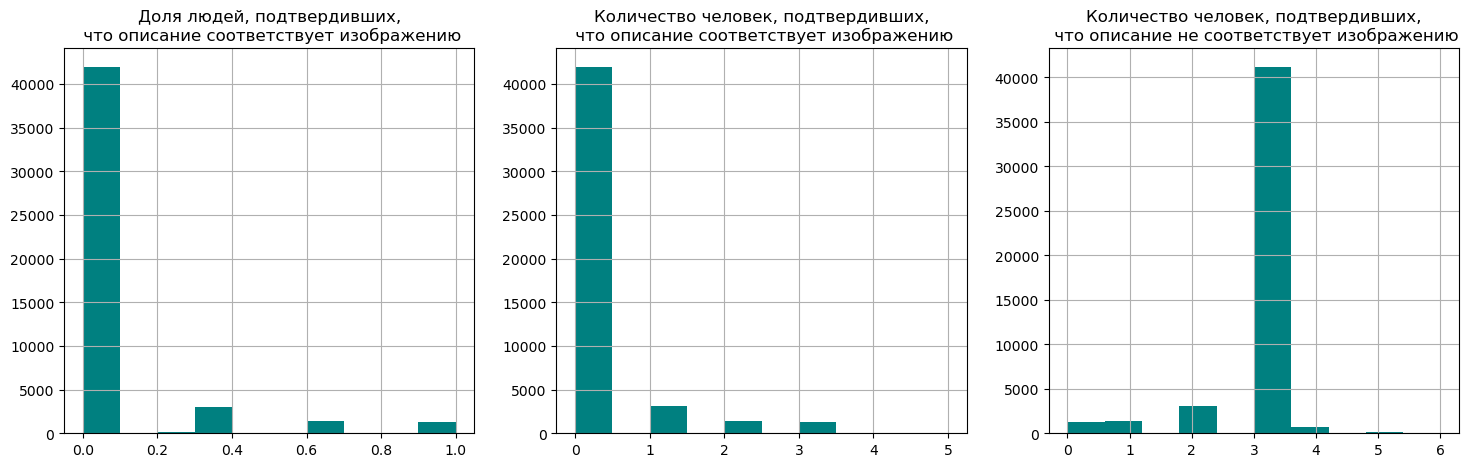

In [7]:
# визуализация данных
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

crowd_annotat['fraction'].hist(ax=axes[0], color='teal')
axes[0].set_title("Доля людей, подтвердивших,\n что описание соответствует изображению")

crowd_annotat['conf_cnt'].hist(ax=axes[1], color='teal')
axes[1].set_title("Количество человек, подтвердивших,\n что описание соответствует изображению")

crowd_annotat['not_conf_cnt'].hist(ax=axes[2], color='teal')
axes[2].set_title("Количество человек, подтвердивших,\n что описание не соответствует изображению")

plt.show()

__Проанализируем общее число респондентов:__

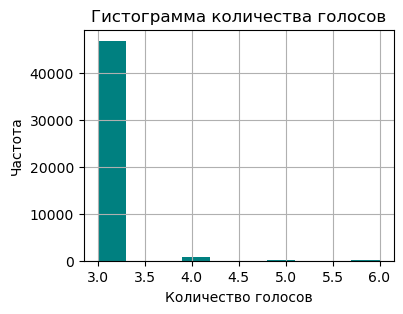

In [8]:
# вычисляем сумму conf_cnt и not_conf_cnt для каждой записи
crowd_annotat['total_votes'] = crowd_annotat['conf_cnt'] + crowd_annotat['not_conf_cnt']

plt.figure(figsize=(4, 3))
crowd_annotat['total_votes'].hist(color='teal')
plt.title("Гистограмма количества голосов")
plt.xlabel("Количество голосов")
plt.ylabel("Частота")
plt.show()

> Низкая доля подтверждений (fraction), это может свидетельствовать о низкой уверенности пользователей в соответствии описания и изображения.
>
>Значительный разброс в числе подтверждений (conf_cnt) и неподтверждений (not_conf_cnt), что может указывать на несогласие между разными пользовательскими оценками.
>
>Высокое количество неподтверждений (not_conf_cnt), что может быть вызвано неправильным описанием или изображением.
>
>Общее число респондентов редко превышает трех человек, это дает основание склоняться к оценке экспертов.

### Числовы признаки датасета expert_annotat

In [9]:
# статистика для expert_annotat
console.print('[bold]Статистика для expert_annotat:[/bold]')
print(expert_annotat.describe())

Статистика для expert_annotat:

             exp_1        exp_2        exp_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000


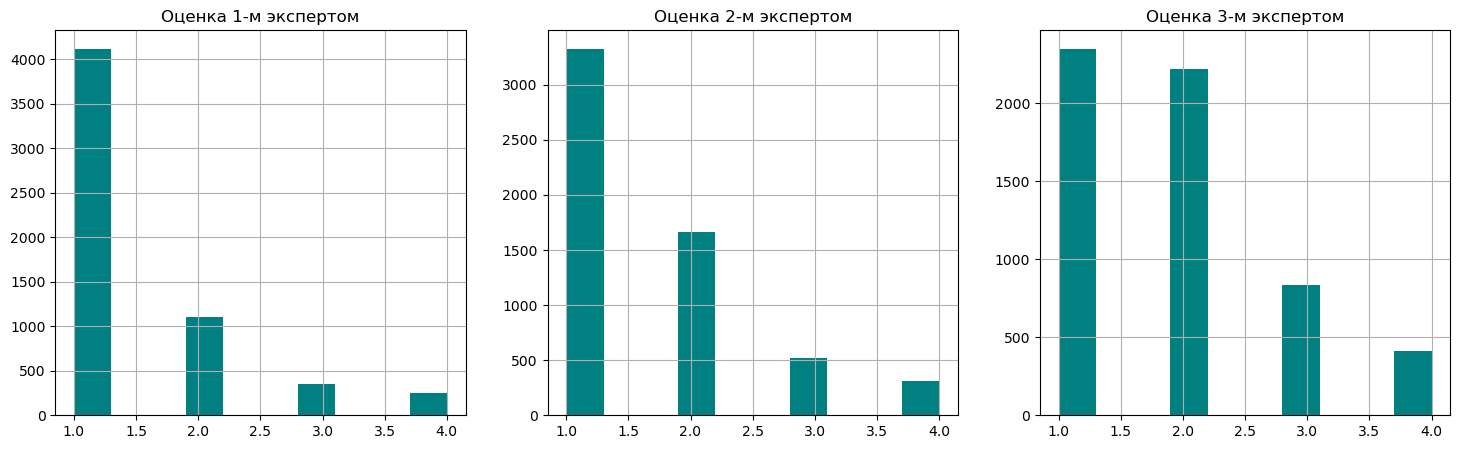

In [10]:
# визуализация данных
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

expert_annotat['exp_1'].hist(ax=axes[0], color='teal')
axes[0].set_title("Оценка 1-м экспертом")

expert_annotat['exp_2'].hist(ax=axes[1], color='teal')
axes[1].set_title("Оценка 2-м экспертом")

expert_annotat['exp_3'].hist(ax=axes[2], color='teal')
axes[2].set_title("Оценка 3-м экспертом")

plt.show()

> Данные от экспертор менее склонны к низким оценкам и имеют меньшую вариабельность. 

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Юридические ограничения

</div>

Поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

Так как в данных отсутсвует информация о возрасте людей на фотографиях, нет прямой возможности очистить от них данные: 
  - выберем фотографии с изображением детей,
  - отсортируем тренировочный датасет по найденным фотографиям,
  - проведем очистку и первичную обработку коментариев,
  - токенизирует и приведем токены к лемме,
  - проведем частотный анализ слов, выделев слова, связанные с детьми и подростками.

In [11]:
# фотографии с изображением детей
child = pd.read_csv('data/child.csv')
display(child.head(2))

,image
0,3767841911_6678052eb6.jpg
1,106490881_5a2dd9b7bd.jpg


__Выведем на экран несколько фотографий__

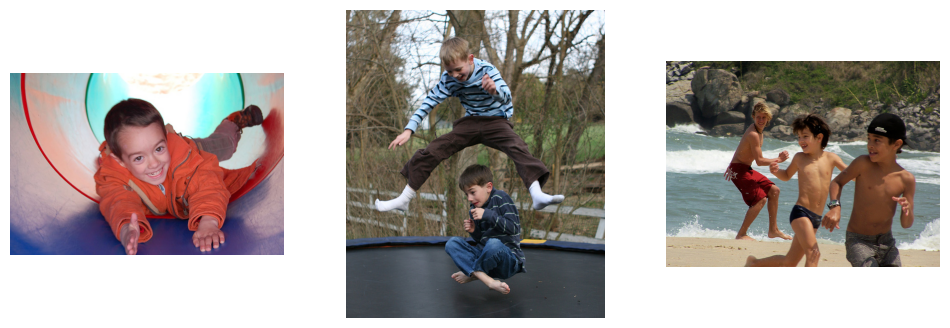

In [12]:
# путь к файлам
image_folder = 'data/train_images/'

# количество изображений, в выборке
num_images = 3

# выборка
selected_rows = child.sample(n=num_images, random_state=RANDOM_SEED)

# визуализация
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

for i, (index, row) in enumerate(selected_rows.iterrows()):
    image_filename = row['image']  
    image_path = os.path.join(image_folder, image_filename)
    
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

__Записи датасета, содержащие изображения детей__

In [13]:
df_child = child.merge(train_df, on='image', how='inner')[['image', 'query_text']]
display(df_child.head(2))

,image,query_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .


__Предобработка текста__

In [14]:
# функция для первичной обработки текста
def clean_text(txt):
    txt = txt.lower() # перевод в нижний регист
    txt = re.sub(LETTERS, ' ', txt) #не буквенные символы меняем на пробел
    txt = re.sub(SPACES, r'\1', txt) #повторяющиеся пробелы меняем на один пробел
    return txt

df_child['clean_text'] = df_child['query_text'].apply(clean_text)
display(df_child.head(2))

,image,query_text,clean_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,a dog jumps to catch a red frisbee in the yard
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,a black and white dog prepares to catch a frisbee


__Удаление стоп-слов__

In [15]:
# загрузка стоп-слов для английского языка
english_stopwords = stopwords.words('english')

# функция для удаления стоп-слов и токенизации текста
def stopwords_tokenize(x):
    tokens = word_tokenize(x)
    tokenization = [word for word in tokens if not word in english_stopwords]
    return ' '.join(tokenization)

df_child['clean_text'] = df_child['clean_text'].apply(stopwords_tokenize)
display(df_child.head(2))

,image,query_text,clean_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,dog jumps catch red frisbee yard
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,black white dog prepares catch frisbee


__Лемматизация текста__

In [16]:
# экземпляр WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def penn2morphy(penntag):
    # словарь для соответствия тегов Penn Treebank тегам WordNet.
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]] # соответствующий тег WordNet
    except:
        return 'n' # (существительное) по умолчанию
    
def lemmatize_text(text): 
    # функция принимает на вход строку текста и выполняет лемматизацию
    # возвращается строку из лемматизированных слов
    return ' '.join(lemmatizer.lemmatize(word, pos=penn2morphy(tag)) for word, tag in pos_tag(word_tokenize(text)))

df_child['clean_text'] = df_child['clean_text'].apply(lemmatize_text)
display(df_child.head(2))

,image,query_text,clean_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,dog jump catch red frisbee yard
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,black white dog prepares catch frisbee


__Токенизация и частотный анализ текста__

In [17]:
# токенизация текста
df_child['tokens'] = df_child['clean_text'].apply(lambda x: x.split())
display(df_child.head(2))

,image,query_text,clean_text,tokens
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,dog jump catch red frisbee yard,"[dog, jump, catch, red, frisbee, yard]"
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,black white dog prepares catch frisbee,"[black, white, dog, prepares, catch, frisbee]"


In [18]:
# список всех токенов
tokens_list = [item for sublist in df_child['tokens'].to_list() for item in sublist]
# частотность токенов
freq_dist = FreqDist(tokens_list)

In [19]:
# перевод частотности в датафрейм
freq_df = pd.DataFrame.from_dict(freq_dist, orient='index', columns=['freq'])
# сортировка
freq_df = freq_df.sort_values(by='freq', ascending=False)
# наиболее частые слова
print(freq_df.index[:100])

Index(['dog', 'man', 'two', 'boy', 'girl', 'woman', 'white', 'child', 'young',
       'wear', 'play', 'little', 'stand', 'blue', 'jump', 'red', 'black',
       'water', 'shirt', 'sit', 'people', 'run', 'smile', 'front', 'walk',
       'beach', 'pool', 'swing', 'hold', 'player', 'ball', 'brown', 'look',
       'camera', 'next', 'person', 'group', 'men', 'snow', 'field', 'hat',
       'green', 'basketball', 'near', 'large', 'one', 'building', 'small',
       'three', 'yellow', 'watch', 'slide', 'grass', 'street', 'rid', 'orange',
       'tree', 'rock', 'pink', 'kid', 'another', 'ocean', 'jacket', 'baby',
       'dress', 'crowd', 'pose', 'dirt', 'bike', 'air', 'mouth', 'uniform',
       'soccer', 'catch', 'face', 'background', 'purple', 'park', 'hand',
       'playground', 'sand', 'adult', 'top', 'take', 'sunglass', 'swim',
       'ride', 'table', 'outside', 'city', 'outdoor', 'toddler', 'around',
       'car', 'beside', 'hair', 'dance', 'football', 'strip', 'toy'],
      dtype='object')


__Список слов, относящихся к детям__

In [20]:
child_list = ['boy', 'girl', 'child', 'young', 'baby', 'teenage', 'kid', 'toddler']

> Определен список слов, отпределяющий изображение детей в наборе данных.

## Удаление записей содержащие в описании слова, относящихся к детям.

In [21]:
# функция по обработке текста
def clean_tokenize_text(text):
    text = clean_text(text)
    text = stopwords_tokenize(text)
    text = lemmatize_text(text)
    return text.split()

# функция для поиска слов, относящихся к детям
def child(x):
    if any(i in x for i in child_list): return 'child'
    return 'not_a_child'

In [22]:
# обработка датасета с данными для тренировки
train_df['tokens'] = train_df['query_text'].apply(clean_tokenize_text)
train_df['child'] = train_df['tokens'].apply(child)
display(train_df.head(2))

,image,query_id,query_text,tokens,child
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .,"[young, child, wear, blue, goggles, sit, float, pool]",child
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .,"[young, child, wear, blue, goggles, sit, float, pool]",child


In [23]:
# исключение записей, относящиеся к детям
train = train_df[train_df['child'] != 'child'][['image', 'query_id', 'query_text']].copy()

In [24]:
print(f'Исключено {len(train_df)-len(train)} записей, относящиеся к детям')

Исключено 1619 записей, относящиеся к детям


> Исключино 1619 пар, из обучающего датасета, которые, исходя из подготовленного списка слов, могут попадать под юридические ограничения.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  Подготовка данных к обучению модели

</div>

## Векторизация текстового описания

(Bidirectional Encoder Representations from Transformers) представляют собой векторные представления слов и текстов, полученные с использованием модели глубокого обучения BERT. Это одна из наиболее мощных и контекстно-зависимых моделей в области обработки естественного языка (NLP). Его уникальность заключается в способности анализировать контексты слов в обоих направлениях в тексте, что позволяет создавать более богатые и семантически точные представления слов.

In [25]:
import torch
import transformers
from torch.nn.utils.rnn import pad_sequence
from tqdm import notebook, tqdm


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4203 entries, 22 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       4203 non-null   object
 1   query_id    4203 non-null   object
 2   query_text  4203 non-null   object
dtypes: object(3)
memory usage: 131.3+ KB


__Паддинг данных__

In [33]:
tqdm.pandas()

# проверяем доступность MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# инициализация токенизатор, конфигурацию и модель BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')
config = transformers.BertConfig.from_pretrained('bert-large-uncased')
model = transformers.BertModel.from_pretrained('bert-large-uncased', config=config).to(device)
# токенизируем текста
tokenized = train['query_text'].progress_apply(lambda x:
                                           tokenizer.encode(x, max_length=512, 
                                                            truncation=True, add_special_tokens=True)) 

padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)  

attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████| 4203/4203 [00:00<00:00, 9442.29it/s]


__Эмбеддинги текста__

In [34]:
# создание эмбедингов
batch_size = 467
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.Tensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

text_features = np.concatenate(embeddings)

# сохранение эмбеддингов в файл
np.save('data/text_features.npy', text_features)

  0%|          | 0/9 [00:00<?, ?it/s]

In [35]:
# загрузка эмбеддингов из файла
text_features = np.load('data/text_features.npy')
# дополнение датасета эмбедингами 
train['text_embeddings'] = text_features.tolist()

>Эмбеддинги текста с использованием модели BERT представляют собой мощный инструмент для анализа текстовых данных. BERT учитывает контекст слов и их взаимодействие в предложении, что позволяет получать эмбеддинги, более точно передающие семантику текста.